In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, buto they won't be saved outside of the current session

/kaggle/input/niazi-coffe-shop-sale/Coffee Shop Sales.xlsx


## 1. Introducción: 

En la industria del café, entender el comportamiento de compra de los clientes es clave para optimizar operaciones, maximizar ingresos y mejorar la experiencia del consumidor. Este análisis busca transformar datos de transacciones en insights accionables que puedan ayudar a la toma de decisiones estratégicas en un coffee shop con múltiples sucursales.

A través del uso de herramientas de análisis de datos en Python, exploraremos tendencias y patrones en las ventas para responder preguntas clave como:

- ¿Cuáles son las horas pico de ventas y cómo pueden optimizarse los recursos en esos momentos?
- ¿Qué categorías de productos generan más ingresos y cuáles tienen menor rotación?
- ¿Existen diferencias significativas en el desempeño de las distintas sucursales?
- ¿Cómo varían las ventas a lo largo del mes y del año? ¿Se pueden anticipar períodos de mayor demanda?
- ¿Existe una relación entre el precio y la cantidad vendida de los productos?

Realizaremos un análisis exploratorio de los datos (EDA), complementado con visualizaciones que nos permitirán extraer conclusiones clave para la optimización de la operación del coffee shop.



## 2. Importación de librerías y carga de datos:

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar los datos y mostrar primeras filas
df = pd.read_excel('/kaggle/input/niazi-coffe-shop-sale/Coffee Shop Sales.xlsx')
df.head()


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


## 3. Exploración inicial de los datos:¶
Procederemos a ver:

- cantidad de filas y columnas
- tipo de datos
- buscar nulos y duplicados

In [3]:
# información sobre el número de filas y columnas
df.shape

(149116, 11)

In [4]:
# buscamos nulos
df.isnull().sum()

transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64

In [5]:
# informacion mas detallada

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


In [6]:
# nro de duplicados

df.duplicated().sum()

0

In [7]:
# creamos columnas de year, month, day y transaction_time para facilitar el análisis

df["year"] = df["transaction_date"].dt.year
df["month"] = df["transaction_date"].dt.month
df["day"] = df["transaction_date"].dt.day
df["transaction_time"] = pd.to_datetime(df["transaction_time"], format="%H:%M:%S").dt.hour
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,year,month,day
0,1,2023-01-01,7,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,2023,1,1
1,2,2023-01-01,7,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023,1,1
2,3,2023-01-01,7,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,2023,1,1
3,4,2023-01-01,7,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2023,1,1
4,5,2023-01-01,7,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023,1,1


## 4. Análisis y visualización de los datos:

### Cantidad de transacciones por hora del día

Buscamos evaluar cuales son las horas pico del negocio y como se distribuyen las ventas a través del día.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


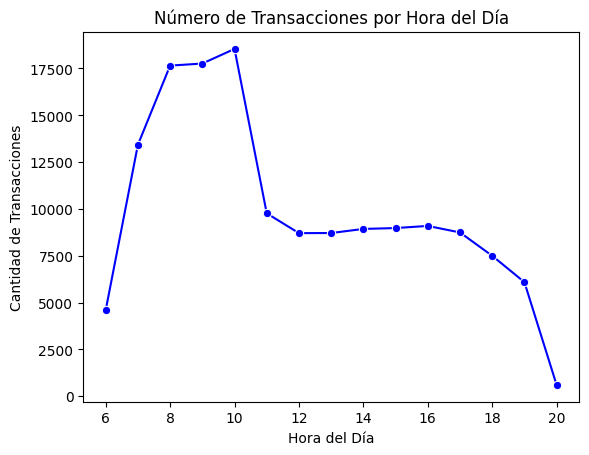

In [8]:
# Agrupar por hora y contar transacciones
hourly_sales = df.groupby("transaction_time")["transaction_id"].count().reset_index()

# Graficar
sns.lineplot(x="transaction_time", y="transaction_id", data=hourly_sales, marker="o", color="b")
plt.title("Número de Transacciones por Hora del Día")
plt.xlabel("Hora del Día")
plt.ylabel("Cantidad de Transacciones")
plt.show()

Se puede apreciar que la mayor actividad del negocio es en la mañana, alcanzando el pico de ventas a las 10 AM, hora a la que caen las ventas, para mantenerse estable hasta la tarde, cerca de la hora de cierre.

### Productos más vendidos

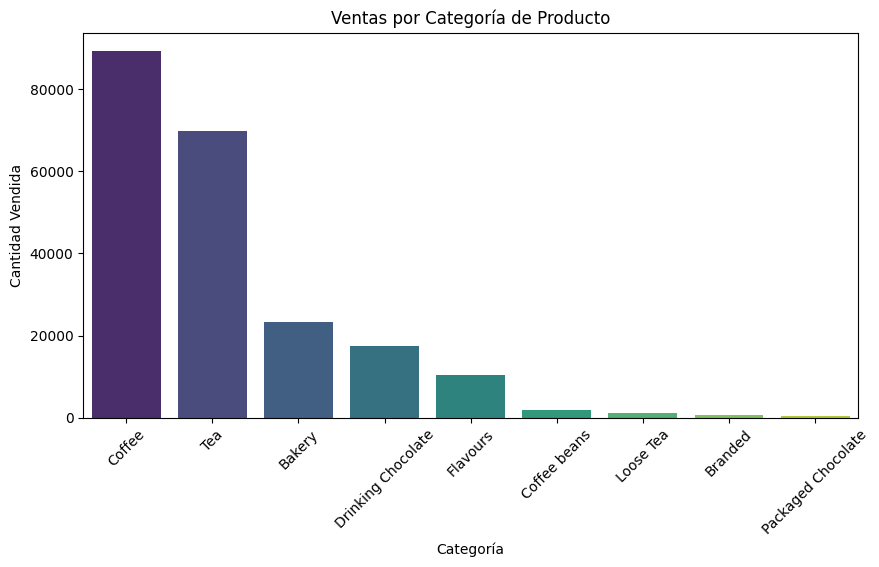

In [9]:
# Agrupar por categoría y sumar las cantidades vendidas
category_sales = df.groupby("product_category")["transaction_qty"].sum().reset_index()

# Ordenar de mayor a menor
category_sales = category_sales.sort_values(by="transaction_qty", ascending=False)

# Graficar
plt.figure(figsize=(10,5))
sns.barplot(x="product_category", y="transaction_qty", data=category_sales, palette="viridis")
plt.xticks(rotation=45)
plt.title("Ventas por Categoría de Producto")
plt.xlabel("Categoría")
plt.ylabel("Cantidad Vendida")
plt.show()

Indiscutidamente los productos con mayor venta son el café y el té, y luego con una cantidad menor vendida se encuentran los productos de pastelería. Sería recomendable analizar si es posible incrementar las ventas de productos de pastelería, que son un excelente complemento con el té y el café.

### Ventas por sucursal

¿Cuál es la sucursal que vende más?

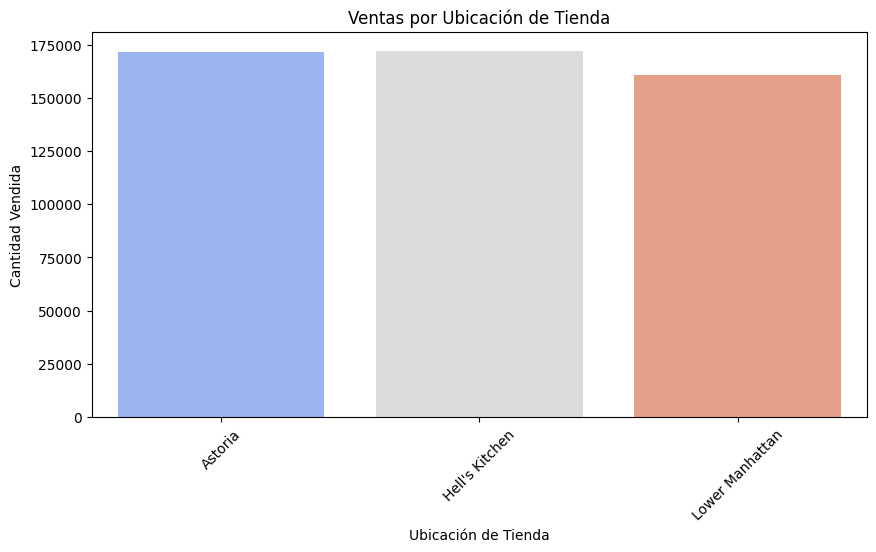

In [16]:
store_sales = df.groupby("store_location")["unit_price"].sum().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x="store_location", y="unit_price", data=store_sales, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Ventas por Ubicación de Tienda")
plt.xlabel("Ubicación de Tienda")
plt.ylabel("Cantidad Vendida")
plt.show()



La cafetería cuenta con 3 sucursales dentro de la ciudad de Nueva York. Las tres sucursales tienen un nivel de venta similar cercano a los USD 175.000. Siendo Lower Manhattan la sucursal que tiene un desempeño mas bajo de las tres. Sería relevante conocer los motivos del desempeño mas bajo para al menos poder igualar los niveles de venta de las otras dos sucursales.

### Distribución de precios

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


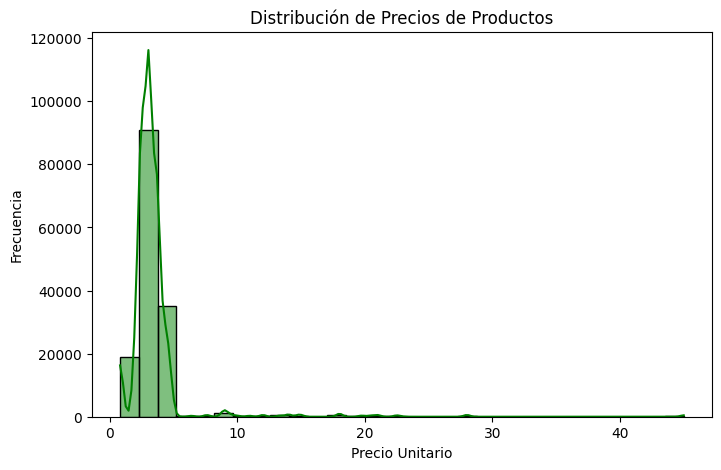

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(df["unit_price"], bins=30, kde=True, color="g")
plt.title("Distribución de Precios de Productos")
plt.xlabel("Precio Unitario")
plt.ylabel("Frecuencia")
plt.show()

Se puede ver que la mayoria de las ventas son de productos con precios que se encuentran entre los 4 y los 6 dolares, con escasas ventas de algunos productos más exclusivos de mas de USD 40.

### Relación entre precio y cantidad vendida

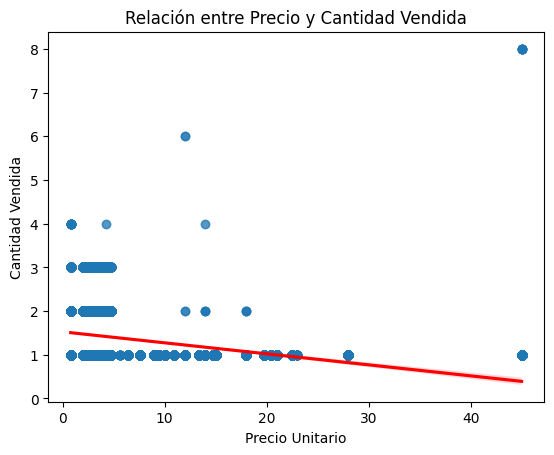

In [17]:
sns.regplot(x="unit_price", y="transaction_qty", data=df, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title("Relación entre Precio y Cantidad Vendida")
plt.xlabel("Precio Unitario")
plt.ylabel("Cantidad Vendida")
plt.show()

Se observa una correlacion negativa entre el precio y la cantidad vendida.

### Ventas por año

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


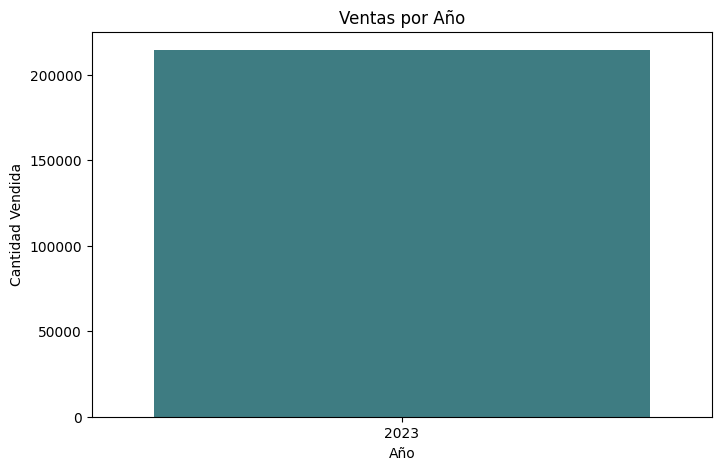

In [13]:
yearly_sales = df.groupby("year")["transaction_qty"].sum().reset_index()

# Graficar
plt.figure(figsize=(8,5))
sns.barplot(x="year", y="transaction_qty", data=yearly_sales, palette="crest")
plt.title("Ventas por Año")
plt.xlabel("Año")
plt.ylabel("Cantidad Vendida")
plt.show()

Solamente hay un año para analizar

### Ventas por mes

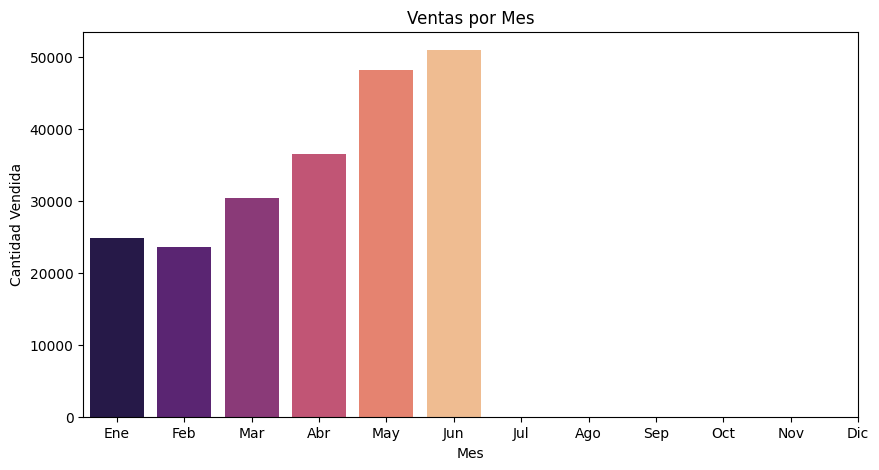

In [14]:
# Agrupar por mes
monthly_sales = df.groupby("month")["transaction_qty"].sum().reset_index()

# Graficar
plt.figure(figsize=(10,5))
sns.barplot(x="month", y="transaction_qty", data=monthly_sales, palette="magma")

plt.xticks(range(12), ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])
plt.title("Ventas por Mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad Vendida")
plt.show()

Solo hay datos de la operación por seis meses, con un crecimiento sostenido en las ventas.

## 5 . Conclusiones: 

-  **Horas Pico y Gestión de Recursos**

📌 Insight: Se identificaron horarios de alta demanda, con un claro aumento en las transacciones durante las mañanas (7 AM - 10 AM) y otro pico menor en la tarde (3 PM - 5 PM).


✅ Acción recomendada: Ajustar la asignación de personal en estos horarios para mejorar la eficiencia del servicio y reducir tiempos de espera. También se pueden diseñar promociones específicas para horas de baja demanda.

-  **Desempeño por Categoría de Producto**

📌 Insight: Las bebidas de café representan la mayor parte de las ventas, pero la categoría Bakery (panadería y pastelería) muestra un desempeño menor en comparación con su potencial.

✅ Acción recomendada: Evaluar estrategias para potenciar las ventas de productos de Bakery, como combos con café o descuentos en compras combinadas.
Revisar la oferta actual y considerar incorporar productos más alineados con las preferencias de los clientes.
Destacar estos productos en el menú o en la exhibición en tienda para incentivar su compra impulsiva.

- **Comparación entre Sucursales**

📌 Insight: Existen diferencias en las ventas entre las tres sucursales, con una tienda claramente bajo a las otras en volumen de transacciones.


✅ Acción recomendada: Evaluar qué factores diferencian a la sucursal con mejor rendimiento (ubicación, promociones, fidelización) y replicar estrategias en las otras tiendas.

-  **Relación entre Precio y Cantidad Vendida**

📌 Insight: Se observó que ciertos productos con precios bajos e intermedios tienden a venderse más que los muy caros.

✅ Acción recomendada: Ajustar estrategias de pricing y evaluar si pequeños descuentos o combos pueden incentivar la compra de productos con menor rotación.

